In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from PIL import Image
from tqdm.notebook import tqdm
from tools.image_tools import train_model,get_columns, check_year
from tools.image_tools import *
from random import shuffle
from pathlib import Path

# Capitals

## Create data

In [6]:
import json
json_file_path = "/deezy_datadrive/kaspar-playground/page_segment/annotations/capital_annotations.json"
json_file = json.load(open(json_file_path,'rb'))

In [12]:
from tools.image_tools import draw_rectangles


draw_rectangles(json_file,
                orig_path=Path("/deezy_datadrive/kaspar-playground/page_segment/to_annotate_capitals"),
                out_path=Path("/deezy_datadrive/kaspar-playground/page_segment/capitals"))


# Train model

In [16]:
target = 'capitals'
path = Path(target)
root = Path("/deezy_datadrive/kaspar-playground/page_segment")
split_by_pct=.1
bs=1
wd=1e-2#1e-2
epochs=20
size=(750,750)
export_path= root / 'models' / 'capitals'

In [17]:
# learn = train_model(path,
#             root = root,
#             export_path= root / 'models'
# )

In [18]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

path_lbl = root /path/'labels'
path_img = root / path/'images'
codes = np.array(['page','capital'])

src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(split_by_pct)
        .label_from_func(get_y_fn, classes=codes))

data = (src.transform(size=size, tfm_y=True)  # (900,600)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

    
        

In [26]:
data

ImageDataBunch;

Train: LabelList (178 items)
x: SegmentationItemList
Image (3, 750, 750),Image (3, 750, 750),Image (3, 750, 750),Image (3, 750, 750),Image (3, 750, 750)
y: SegmentationLabelList
ImageSegment (1, 750, 750),ImageSegment (1, 750, 750),ImageSegment (1, 750, 750),ImageSegment (1, 750, 750),ImageSegment (1, 750, 750)
Path: /deezy_datadrive/kaspar-playground/page_segment/capitals/images;

Valid: LabelList (19 items)
x: SegmentationItemList
Image (3, 750, 750),Image (3, 750, 750),Image (3, 750, 750),Image (3, 750, 750),Image (3, 750, 750)
y: SegmentationLabelList
ImageSegment (1, 750, 750),ImageSegment (1, 750, 750),ImageSegment (1, 750, 750),ImageSegment (1, 750, 750),ImageSegment (1, 750, 750)
Path: /deezy_datadrive/kaspar-playground/page_segment/capitals/images;

Test: None

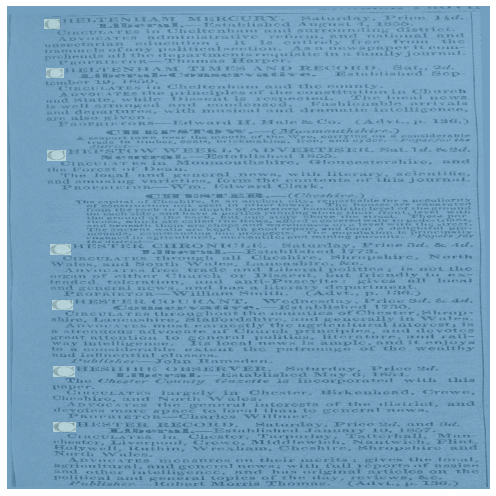

In [19]:
data.show_batch(2, figsize=(10,7))

In [11]:
#F1 = MultiLabelFbeta(average="weighted")

In [20]:
def accuracy(input, target):
    """computes pixel level accuracy"""
    target = target.squeeze(1)
    
    return (input.argmax(dim=1)==target).float().mean()


In [21]:
learn = unet_learner(data, 
                     models.resnet18, 
                     metrics=accuracy, 
                     wd=wd, 
                     bottle=True, 
                     self_attention=True, 
                     blur=True)

epoch     train_loss  valid_loss  accuracy  time    
0         1.555596    #na#        01:43     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


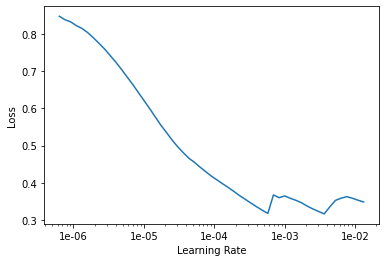

In [22]:

#learn.data = data
lr_find(learn)
learn.recorder.plot()


In [23]:
lr = 1e-4
#learn.fit_one_cycle(epochs, slice(lr), pct_start=0.8)

In [24]:
#learn.save(root / 'models'/ 'unet-stage-1')

In [25]:
#learn.load(root / 'models'/ 'unet-stage-1')

In [27]:
learn.unfreeze()
lrs = slice(lr/100,lr)
learn.fit_one_cycle(10, lrs, pct_start=0.9)

epoch     train_loss  valid_loss  accuracy  time    
0         0.047630    0.032096    0.991474  03:33     
1         0.011926    0.008754    0.996713  03:32     
2         0.006760    0.006063    0.997645  03:31     
3         0.003932    0.003951    0.998406  03:31     
4         0.003259    0.003057    0.998786  03:31     
5         0.002389    0.002652    0.998978  03:31     
6         0.002082    0.002986    0.998888  03:32     
7         0.002016    0.002901    0.999015  03:31     
8         0.001399    0.002323    0.999098  03:31     
9         0.001016    0.001796    0.999347  03:31     


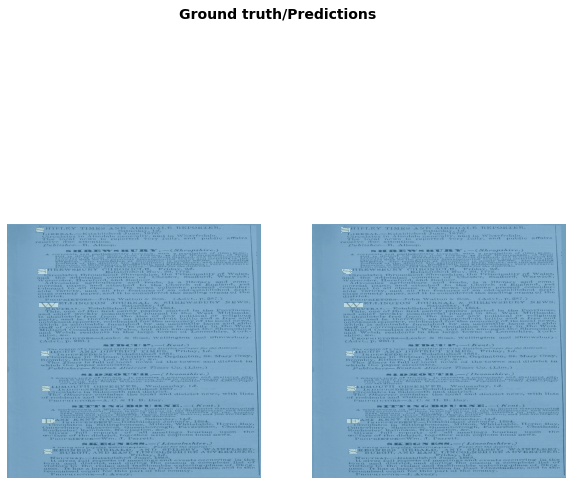

In [28]:
learn.show_results(2, figsize=(10,10))

In [29]:
model_folder = Path(export_path)
model_folder.mkdir(exist_ok=True)
model_path = model_folder / 'export.pkl'
learn.export(model_path)

In [31]:
!ls -al {model_path}

-rw-rw-r-- 1 kbeelen kbeelen 177562989 Feb 11 11:26 /deezy_datadrive/kaspar-playground/page_segment/models/capitals/export.pkl


# Load and apply model

move to image manipulation notebook

In [ ]:
# model_folder = Path('/deezy_datadrive/kaspar-playground/page_segment/models')
# learn = load_learner(model_folder)

In [30]:
#image_paths = list(Path("/deezy_datadrive/kaspar-playground/npd/Data/Original/").glob("**/Image_processed/*.png"))
#print(len(image_paths))
#image_paths = [p for p in image_paths if check_year(p) >= 1860]
#save_capitals_test(image_paths, learn,ignore_files=[])

# Output for OCR Transcription

In [34]:
image_paths = list(Path("/deezy_datadrive/kaspar-playground/npd/Data/Original/").glob("**/Image_processed_final/*.png"))
print(len(image_paths))
image_paths = [p for p in image_paths if check_year(p) >= 1855]
shuffle(image_paths)


5991


In [37]:
selected_images = image_paths[:100]
ocr_path = Path('/deezy_datadrive/kaspar-playground/npd/OCR')
ocr_path.mkdir(exist_ok=True)
for img in selected_images:
    shutil.copy(img, ocr_path / img.name)

# Capital Detection with bounding box


Use following resources

https://forums.fast.ai/t/object-detection-databunch/38812/4

https://francescopochetti.com/fast-ai-dl2-lesson-9-single-shot-detection-detailed-walkthrough/

In [12]:
import json
json_file_path = "/deezy_datadrive/kaspar-playground/page_segment/annotations/capital_annotations.json"
json_file = json.load(open(json_file_path,'rb'))

In [26]:
def json2df(json):
    rows = []
    for img, annotations in json['_via_img_metadata'].items():
        for an in annotations['regions']:
            row = [annotations['filename']]
        
            row.append(np.array([an['shape_attributes']['x'],an['shape_attributes']['y'],
                    an['shape_attributes']['x']+an['shape_attributes']['width'],
                    an['shape_attributes']['y']+an['shape_attributes']['height']]))
            row.append(1)

            rows.append(row)
    return pd.DataFrame(rows)

df = json2df(json_file)
df.iloc[0]

0    MPD_1860_040_left.png
1     [252, 367, 327, 449]
2                        1
Name: 0, dtype: object

{'filename': 'MPD_1860_040_left.png',
 'size': 3792196,
 'regions': [{'shape_attributes': {'name': 'rect',
    'x': 252,
    'y': 367,
    'width': 75,
    'height': 82},
   'region_attributes': {'capital': {'capital': True}}},
  {'shape_attributes': {'name': 'rect',
    'x': 261,
    'y': 874,
    'width': 74,
    'height': 80},
   'region_attributes': {'capital': {'capital': True}}},
  {'shape_attributes': {'name': 'rect',
    'x': 266,
    'y': 1278,
    'width': 71,
    'height': 81},
   'region_attributes': {'capital': {'capital': True}}},
  {'shape_attributes': {'name': 'rect',
    'x': 268,
    'y': 1914,
    'width': 76,
    'height': 80},
   'region_attributes': {'capital': {'capital': True}}},
  {'shape_attributes': {'name': 'rect',
    'x': 275,
    'y': 2312,
    'width': 75,
    'height': 80},
   'region_attributes': {'capital': {'capital': True}}},
  {'shape_attributes': {'name': 'rect',
    'x': 287,
    'y': 3010,
    'width': 75,
    'height': 80},
   'region_attribute

In [13]:
json_file.keys()

dict_keys(['_via_settings', '_via_img_metadata', '_via_attributes', '_via_data_format_version', '_via_image_id_list'])

In [9]:
pd.DataFrame.from_dict(json_file)

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.